# Testing the effect of thresholds on LCA calls

CMS001_059_Ra_S10 has many wolbachia contigs, plus bloodmeal (passeriformes)

CMS001_003_Ra_S2 has a lot going on, including anaplasma

CMS002_045c_Rb_S185_L004 has wuhan 6

CMS002_053a_Rb_S7_L004 has Wuhan 9

CMS001_040_Ra_S21 This one has Narnavirus and divergent peribunyavirus hits

## Load libraries and define functions

In [242]:
import pandas as pd
import numpy as np
import boto3
import os
import matplotlib.pyplot as plt
from pylab import rcParams
from lca_functions import *

In [ ]:
s3 = boto3.client('s3')
s3_bucket = "czbiohub-mosquito"

In [203]:
def get_blast_file (sample_names, ntnr):
    blast_fn = [os.path.join("s3://czbiohub-mosquito/contig_quality", x, "blast_"+ntnr+"_filtered.m9") for x in sample_names]
    blast = pd.concat([pd.read_csv(x, sep="\t", header=0).assign(sample=sample_names[i]) for i, x in enumerate(blast_fn)])
    blast = blast.assign(qlen=blast["query"].str.split("_").apply(lambda x: int(x[3])))
    blast = blast.assign(identity_qcov=blast["identity"]/100*blast["qcov"])
    if (ntnr=="nr"):
        blast = blast.assign(identity_qcov=blast["identity"]/100*3*blast["qcov"])
    return (blast)

In [ ]:
def keep_only_discordant_taxids (blast):
    multiple_taxids = blast.groupby(["query"]).apply(lambda x: len(x["taxid"].unique()))>1
    queries_to_keep = list(multiple_taxids.index[multiple_taxids])
    return (blast[blast["query"].isin(queries_to_keep)])

In [327]:
def test_lca_movement (blast_rows, test_range):
    blast_rows = blast_rows.reset_index()
    max_identity_qcov = blast_rows["identity_qcov"].max()
    best_blast_rows = blast_rows[blast_rows["identity_qcov"]==max_identity_qcov]
    best_lca = get_lca(best_blast_rows)["taxid"].iloc[0]
    best_row = best_blast_rows.head(n=1)
    best_lineage = ncbi.get_lineage(best_lca)
    best_lineage.reverse()
    row_indices = [str(list(blast_rows.index[blast_rows["identity_qcov"]>=(max_identity_qcov*x)])) for x in test_range]
    unique_row_indices = list(set(row_indices))
    unique_lca = [get_lca(blast_rows.iloc[(eval(x))])["taxid"] for x in unique_row_indices]
    unique_lca_movement = [best_lineage.index(int(x)) for x in unique_lca]
    lca_movement = [unique_lca_movement[unique_row_indices.index(x)] for x in row_indices]
    output_df = pd.DataFrame({"sample":[blast_rows["sample"].iloc[0]]*len(test_range),
                              "query":[blast_rows["query"].iloc[0]]*len(test_range),
                              "qlen":[blast_rows["qlen"].iloc[0]]*len(test_range),
                              "identity_qcov":test_range*best_row["identity_qcov"].iloc[0],
                              "identity_qcov_prop":test_range,
                              "lca_movement":lca_movement
                             }
                            )
    if (output_df["identity_qcov_prop"].max()<max(test_range)):
        print (output_df)
    return (output_df)
    

In [340]:
def plot_lca_movement(df, ax, xlabel=None, ylabel=None, title=None):
    df.groupby(["sample", "query"]).apply(lambda x: ax.plot(x["identity_qcov_prop"], x["lca_movement"]))
    if (xlabel is not None):
        ax.set_xlabel(xlabel)
    if (ylabel is not None):
        ax.set_ylabel(ylabel)
    if (title is not None):
        ax.set_title(title)



In [346]:
def plot_by_max_metric(df, ntnr, figwidth=10, figheight=10):
    rcParams['figure.figsize'] = figwidth, figheight
    fig = plt.figure()
    metric_range = [0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95]
    fig, axs = plt.subplots(len(metric_range), 1)
    for i, qlen in enumerate(metric_range):
        metric_list = df["identity_qcov"]
        lower = metric_range[i]
        try:
            upper = qlen_limits[i+1]
            subdf = df[(metric_list > lower) & (metric_list <= upper)]
        except:
            subdf = df[metric_list > lower]
        plot_title = ntnr+": max identity_qcov between "+str(lower)+" and "+str(upper)
        if (i==len(metric_range)):
            plot_lca_movement(subdf, axs[i], 
                              xlabel="Proportion of max(identity_qcov)",
                              title=plot_title
                             )
        elif(i==int(len(qlen_limits)/2)):
            plot_lca_movement(subdf, axs[i],
                              ylabel="Increase in taxonomic level relative to species",
                              title=plot_title
                             )
        else:
            plot_lca_movement(subdf, axs[i],
                              title=plot_title
                             )
        axs[i].set_xlim([df["identity_qcov_prop"].min(), 1])
        axs[i].set_ylim([df["lca_movement"].min(), df["lca_movement"].max()])


## Analysis

In [330]:
test_samples = ["CMS001_059_Ra_S10", "CMS001_003_Ra_S2", "CMS002_045c_Rb_S185_L004", "CMS002_053a_Rb_S7_L004", "CMS001_040_Ra_S21"]

Import blast_nt/nr_filtered.m9 files from the contig_quality folders:

In [205]:
blast_nt = get_blast_file(test_samples, "nt")
blast_nr = get_blast_file(test_samples, "nr")

Keep only the queries for which there are discordant blast hits with regards to taxid calls

In [206]:
blast_nt_multiples = keep_only_discordant_taxids(blast_nt)
blast_nr_multiples = keep_only_discordant_taxids(blast_nr)

Using the identity x query coverage (identity_qcov) metric, keep only blast hits with identity_qcov >= threshold x max(identity_qcov) for that query. Compute the LCA based on these blast hits. Evaluate for different thresholds between 0.8-1 to see how much the LCA result changes with different thresholds.

In [331]:
threshold_test_range = np.linspace(0.8, 1, 21)
blast_nt_lca_movement = blast_nt_multiples.groupby("query", as_index=False).apply(test_lca_movement, test_range = threshold_test_range)
blast_nr_lca_movement = blast_nr_multiples.groupby("query", as_index=False).apply(test_lca_movement, test_range = threshold_test_range)

## Results

For each query, plot the changes in LCA level with respect to changes in thresholds.

<Figure size 1080x1800 with 0 Axes>

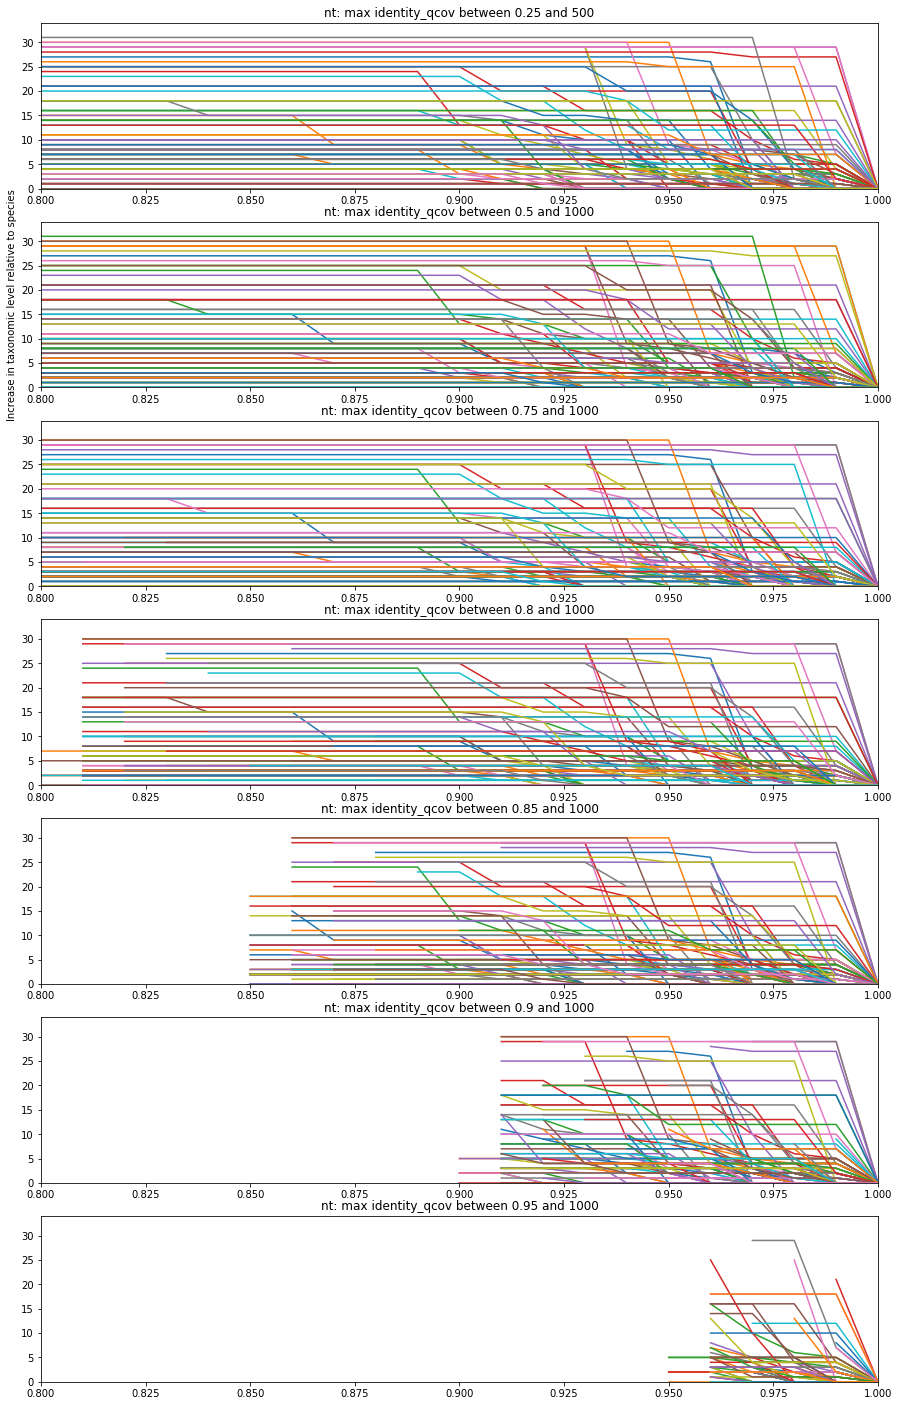

In [347]:
plot_by_max_metric(blast_nt_lca_movement, ntnr="nt", figwidth=15, figheight=25)


<Figure size 1080x1800 with 0 Axes>

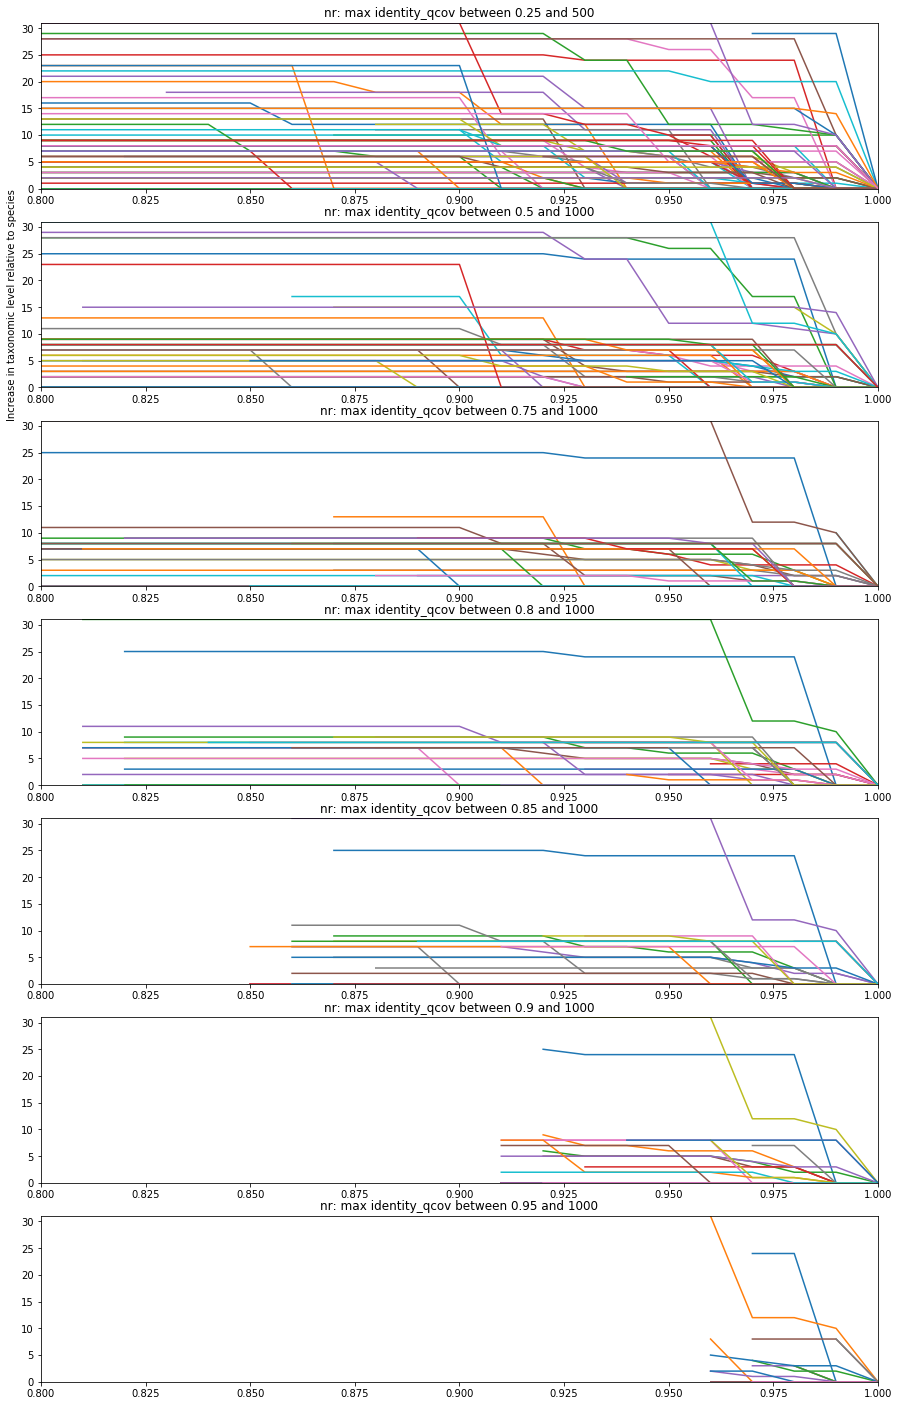

In [348]:
plot_by_max_metric(blast_nr_lca_movement, ntnr="nr", figwidth=15, figheight=25)

The LCA moves up the tree as the threshold for keeping blast hits becomes more relaxed. The rate at which the LCA moves up the tree increases with decreasing value of max(identity x query coverage). 